In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('CDD/gemini_BTCUSD_1hr.csv')
df = df.reset_index()
df.columns = df.iloc[0]#['dt', 'date', 'symbol', 'open', 'high', 'low', 'close', 'volume']
df = df.iloc[1:].sort_values('Date').reset_index(drop=True)
for col in df.columns[-5:]:
    df.loc[:, col] = df[col].astype(float)

price_df = df
price_df['DT'] = pd.to_datetime(price_df.Date)
price_df['Date'] = price_df.DT.dt.date


In [3]:
price_df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume,DT
0,1444309200,2015-10-08,BTCUSD,0.00,245.00,0.00,245.00,0.606654,2015-10-08 13:00:00
1,1444312800,2015-10-08,BTCUSD,245.00,245.00,244.50,245.00,4.453649,2015-10-08 14:00:00
2,1444316400,2015-10-08,BTCUSD,245.00,245.00,244.92,244.92,3.016926,2015-10-08 15:00:00
3,1444320000,2015-10-08,BTCUSD,244.92,244.92,244.25,244.25,3.895252,2015-10-08 16:00:00
4,1444323600,2015-10-08,BTCUSD,244.25,244.99,244.02,244.99,3.920632,2015-10-08 17:00:00


# Find trend curve

<AxesSubplot:>

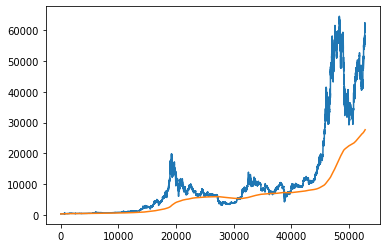

In [4]:
price_df.Close.plot()
price_df.Close.ewm(10000).mean().plot()

((1e-25, -100000.0), 328253336.119294)

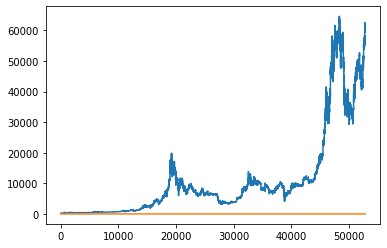

In [26]:
# try to approximate with exponent
xs = np.array(list(price_df.index))
values = price_df.Close.values

errors = {}
for a in np.linspace(1e-25,  1e-15, 100):
    for b in [-1e5, -1e4, -100]:
        preds = np.exp(a * xs + b)# - values[0]
        # print(preds)
        error = ((values - preds)**2).mean()
        errors[(a,b)] = error

price_df.Close.plot()
a, b = min(errors)
plt.plot(np.exp(a*xs+b))
min(errors), errors[min(errors)]


In [5]:
from sklearn.linear_model import Ridge, Lasso

In [23]:
xs = np.array(list(price_df.index))
ys = np.log(price_df.Close.values)

model = Lasso()
model.fit(xs.reshape(-1, 1), ys.reshape(-1, 1))
preds = model.predict(xs.reshape(-1, 1))

In [42]:
a = model.coef_[0]
b = preds[0] - xs[0] * a

In [26]:
diffs = preds - ys
diffs_exp = np.exp(preds) - np.exp(ys)

print('MSE: ', ((diffs)**2).mean())
print('MAE: ', np.abs(diffs).mean())
print('Exp MAE: ', (np.abs(diffs_exp)).mean())

MSE:  0.3287567697861592
MAE:  0.4710504190050328
Exp MAE:  4082.642620218774


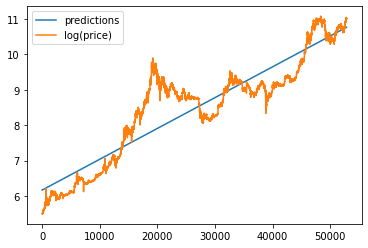

In [28]:
plt.plot(preds)
plt.plot(ys)
plt.legend(['predictions', 'log(price)'])

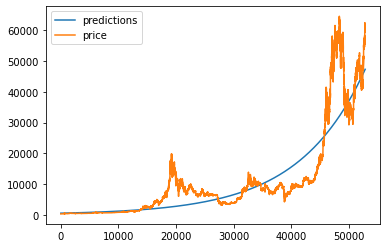

In [29]:
plt.plot(np.exp(preds))
plt.plot(np.exp(ys))
plt.legend(['predictions', 'price'])

In [82]:
price_df['exp_trend'] = np.exp(preds)

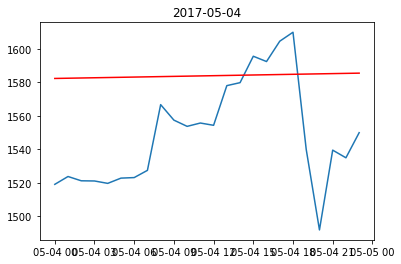

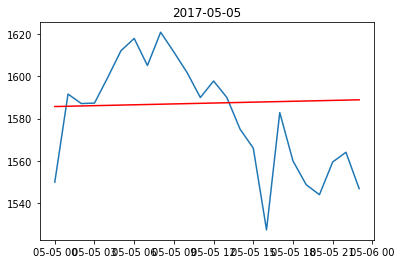

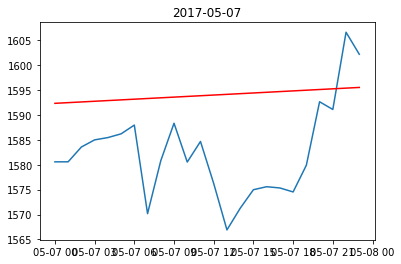

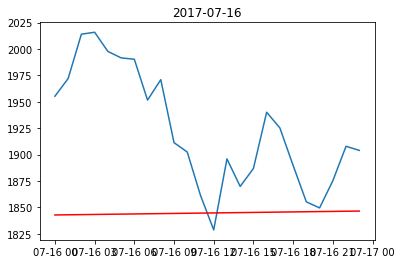

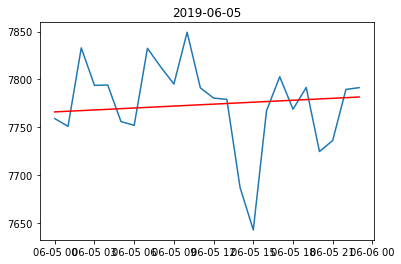

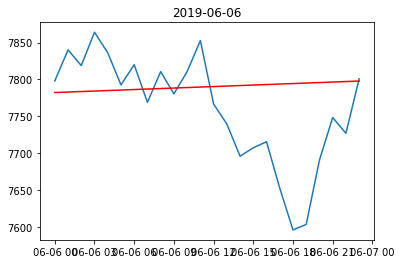

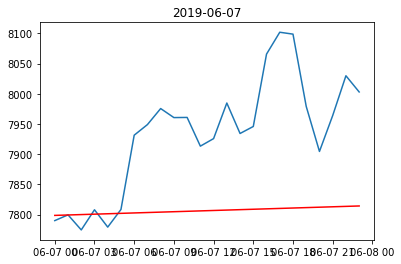

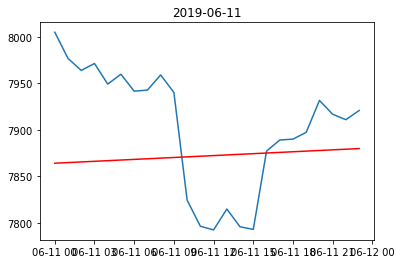

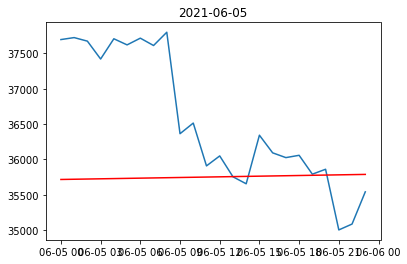

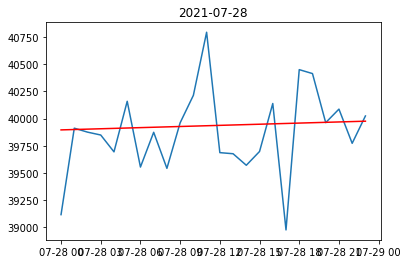

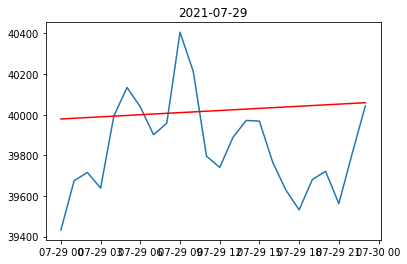

In [84]:
for date in price_df.iloc[np.where(np.abs(np.exp(preds) - np.exp(ys)) < 5)].Date.unique():
    slice = price_df[price_df.Date == date]
    plt.plot(slice.DT, slice.Close)
    plt.plot(slice.DT, slice.exp_trend, c='r')
    plt.title(str(date))
    plt.show()


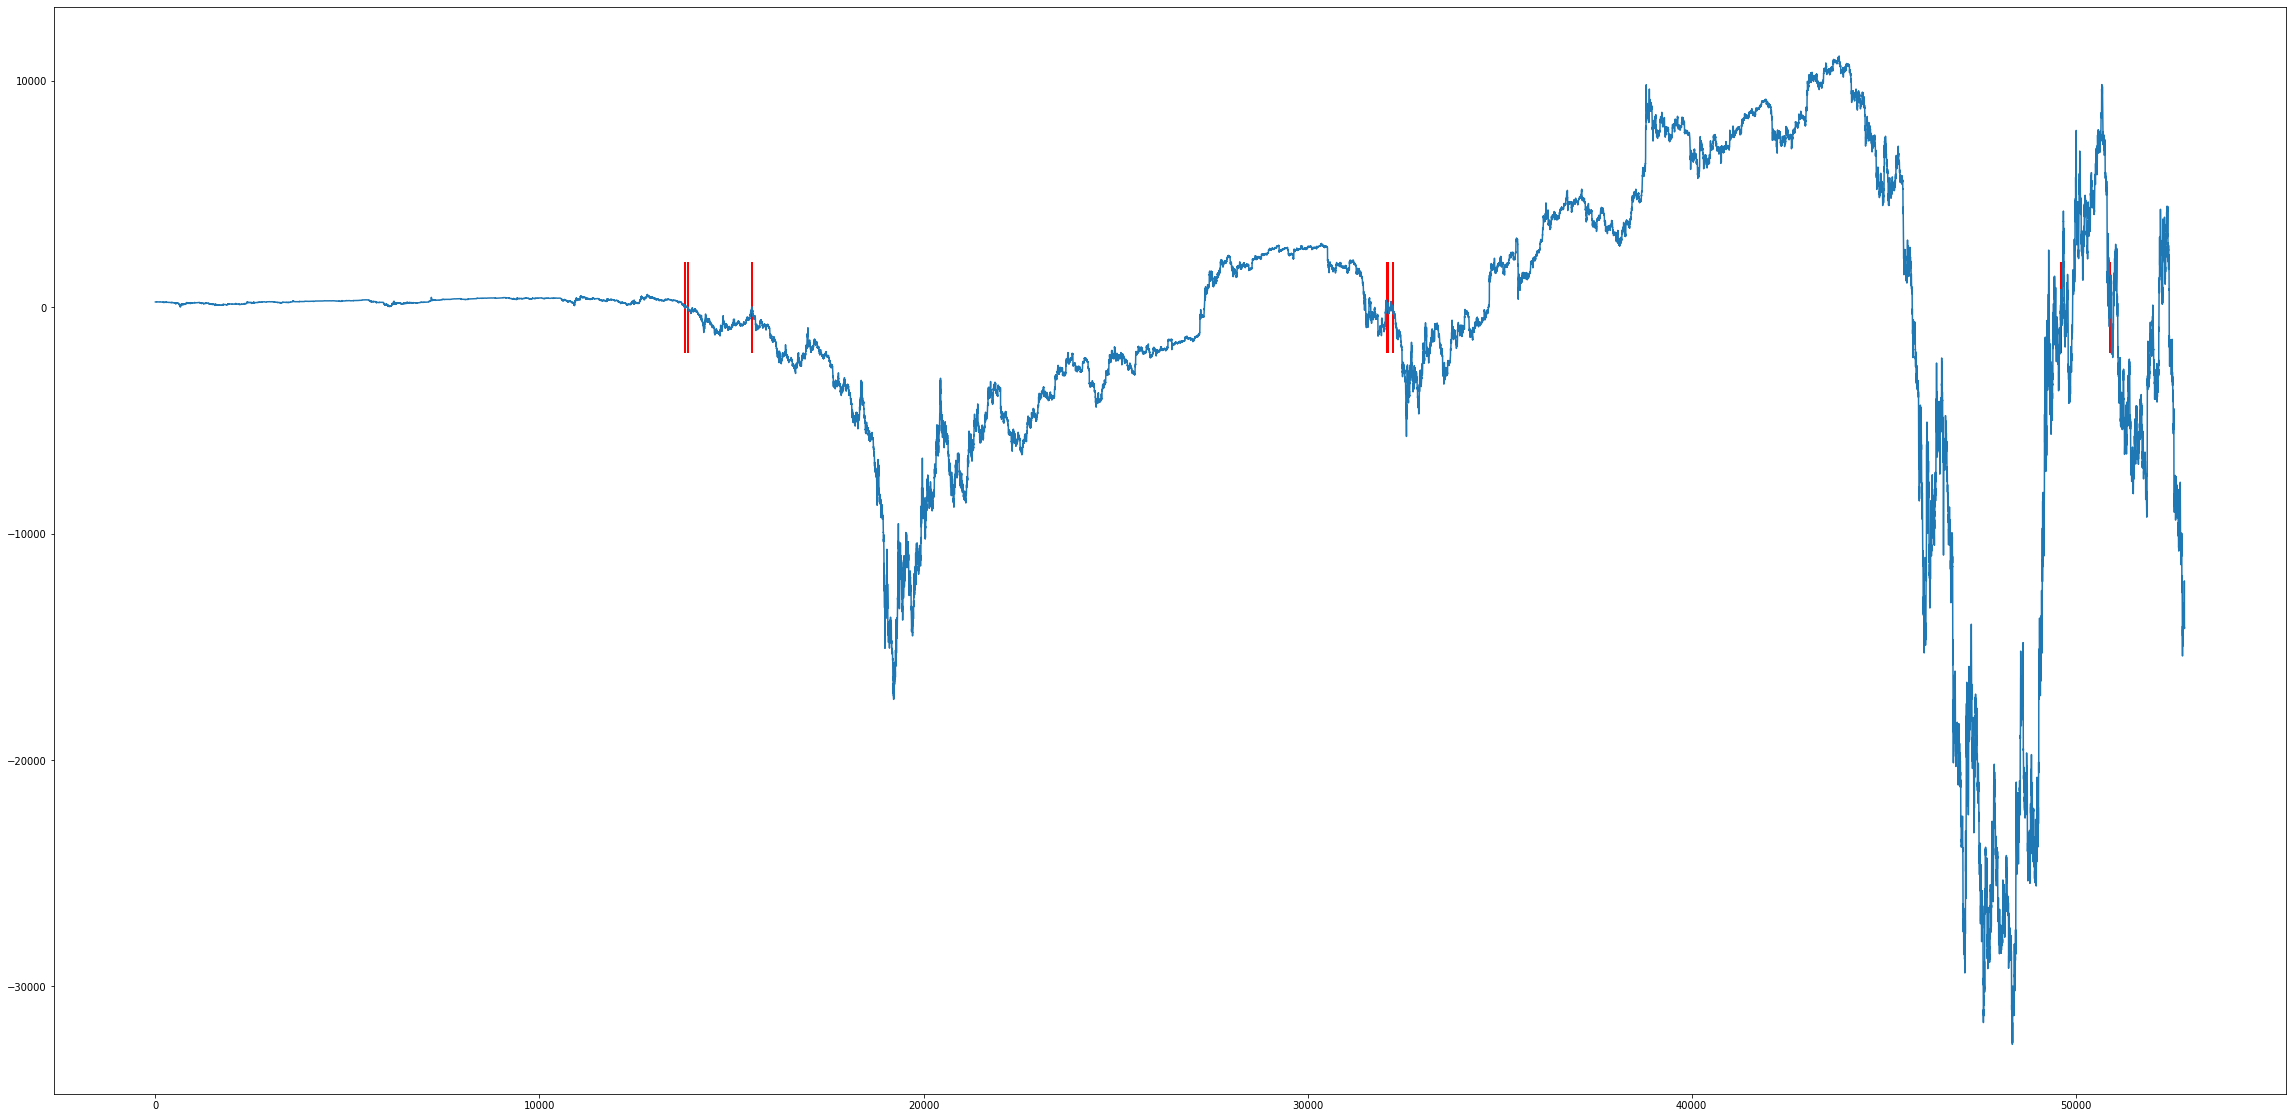

In [74]:
plt.figure(figsize=(40, 20))
plt.plot(np.exp(preds) - np.exp(ys))
plt.vlines(np.where(np.abs(np.exp(preds) - np.exp(ys)) < 5)[0], -2000, 2000, colors='r', linewidth=2)

In [47]:
(np.exp(preds) - np.exp(ys) <= 1).sum()

22153

# EWM criterion

In [4]:
df.Date.min()

datetime.date(2015, 10, 8)

In [5]:
ts = pd.to_datetime('2018-01-01')
df = price_df[price_df.DT > ts].reset_index(drop=True).copy()

# df.Close = np.log10(df.Close)
df['ewm5'] = df.Close.ewm(span=5, min_periods=0).mean()
df['ewm10'] = df.Close.ewm(span=10, min_periods=0).mean()
df['ewm20'] = df.Close.ewm(span=20, min_periods=0).mean()
df['ewm50'] = df.Close.ewm(span=50, min_periods=0).mean()
df['ewm100'] = df.Close.ewm(span=100, min_periods=0).mean()
df['ewm150'] = df.Close.ewm(span=150, min_periods=0).mean()
df['ewm200'] = df.Close.ewm(span=200, min_periods=0).mean()
df['ewm500'] = df.Close.ewm(span=500, min_periods=0).mean()
df['ewm1500'] = df.Close.ewm(span=1500, min_periods=0).mean()

In [6]:
# plt.figure(figsize=(20,10))
# plt.plot(df.DT, df.Close)
# for col in df.columns[-5:]:
#     plt.plot(df.DT, df[col])
# plt.legend(['price'] + list(df.columns[-5:]))

# plt.savefig('ewm1.png', format='png')
# plt.show()

In [7]:
def buy_criterion(x, pct=0.00005):
    delta = x.ewm1500 - x.Close
    return delta > x.Close * pct

buy_df = df[df.apply(buy_criterion, axis=1)]

### 1. EMWs
- write own ema (take only past values)
- take several curves, criterion activated by several emws
- add sell

### 2. Self-similarity
- detect minima by yt vid
- maybe some similarity measure

### 3. 
- test on datasets by day? week

- log or not?

- class with train, where coeffs and thrs are chosen, and test,

- draw graph of profit with graph of coin

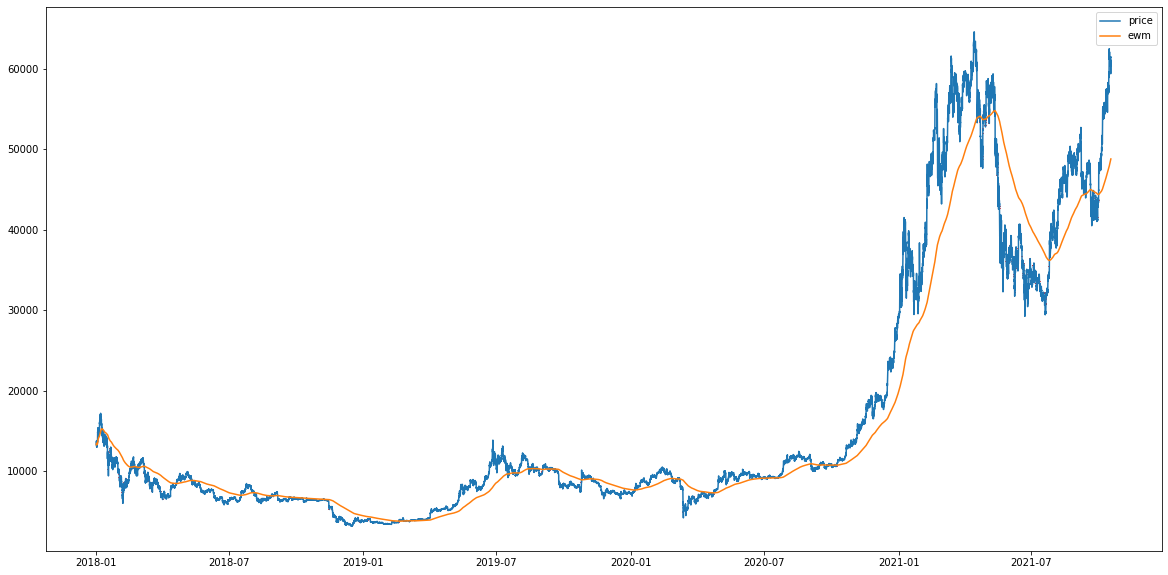

In [11]:
plt.figure(figsize=(20,10))
plt.plot(df.DT, df.Close)
# for col in df.columns[-5:]:
#     plt.plot(df.DT, df[col])

plt.plot(df.DT, df.ewm1500)

height=0.0005
plt.vlines(buy_df.DT, buy_df.Close*(1-height), buy_df.Close*(1+height), colors='red')

plt.legend(['price', 'ewm'])
plt.savefig('ewm_criterion.png', format='png')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df.DT, df.Close)
# for col in df.columns[-5:]:
#     plt.plot(df.DT, df[col])

plt.plot(df.DT, df.ewm1500)

height=0.0005
plt.vlines(buy_df.DT, buy_df.Close*(1-height), buy_df.Close*(1+height), colors='red')

plt.legend(['price', 'ewm'])
plt.savefig('ewm_criterion.png', format='png')
plt.show()

In [9]:
df.Close[0]

13262.85

In [10]:
df.Close.iloc[-1]

61498.12

In [149]:
buy_df = df[df.apply(buy_criterion, axis=1)]

num_buys = buy_df.shape[0]

criterion_cost = buy_df.Close.sum()
initial_cost = df.iloc[0].Close * num_buys
best_cost = df.Close.min() * num_buys
random_cost = np.random.permutation(df.Close.values)[:num_buys].sum()

current_value = num_buys * df.Close.iloc[-1]

criterion_profit = current_value - criterion_cost
initial_profit = current_value - initial_cost
best_profit = current_value - best_cost
random_profit = current_value - random_cost

profit_coeff = 365/(df.shape[0]/24) / initial_cost
print('Cost and profit')
print('Best:      ', round(best_cost, 1), round(df.Close.iloc[-1] / df.Close.min() , 4))
print('Initial:   ', round(initial_cost, 1), round(initial_profit*profit_coeff, 4))
print('Criterion: ', round(criterion_cost, 1), round(criterion_profit*profit_coeff, 4))
print('Random:    ', round(random_cost, 1), round(random_profit*profit_coeff, 4))

Cost and profit
Best:       48259054.6 19.584
Initial:    203823478.8 0.9578
Criterion:  176898991.3 0.9926
Random:     249901738.1 0.8983


In [ ]:
buy_df = df[df.apply(buy_criterion, axis=1)]

num_buys = buy_df.shape[0]

criterion_cost = buy_df.Close.sum()
initial_cost = df.iloc[0].Close * num_buys
best_cost = df.Close.min() * num_buys
random_cost = np.random.permutation(df.Close.values)[:num_buys].sum()

current_value = num_buys * df.Close.iloc[-1]

criterion_profit = current_value - criterion_cost
initial_profit = current_value - initial_cost
best_profit = current_value - best_cost
random_profit = current_value - random_cost

profit_coeff = 365/(df.shape[0]/24) / initial_cost
print('Cost and profit')
print('Best:      ', round(best_cost, 1), round(best_profit*profit_coeff, 4))
print('Initial:   ', round(initial_cost, 1), round(initial_profit*profit_coeff, 4))
print('Criterion: ', round(criterion_cost, 1), round(criterion_profit*profit_coeff, 4))
print('Random:    ', round(random_cost, 1), round(random_profit*profit_coeff, 4))

Cost and profit
Best:       6306971.8 31.1257
Initial:    6737292.2 31.1149
Criterion:  219482285.4 25.7782
Random:     228310576.5 25.5567


# Round number indicator

In [5]:
df = price_df.iloc[30500:31500].reset_index(drop=True).copy()

In [6]:
df['returns'] = df.Close.pct_change()
df['scaled_price'] = df.Close / 10**np.floor(np.log10(df.Close))
df['round_indicator'] = df.scaled_price % 1
df['ewm20'] = df.Close.ewm(span=20, min_periods=0).mean()
df['ewm50'] = df.Close.ewm(span=50, min_periods=0).mean()
df['ewm100'] = df.Close.ewm(span=100, min_periods=0).mean()

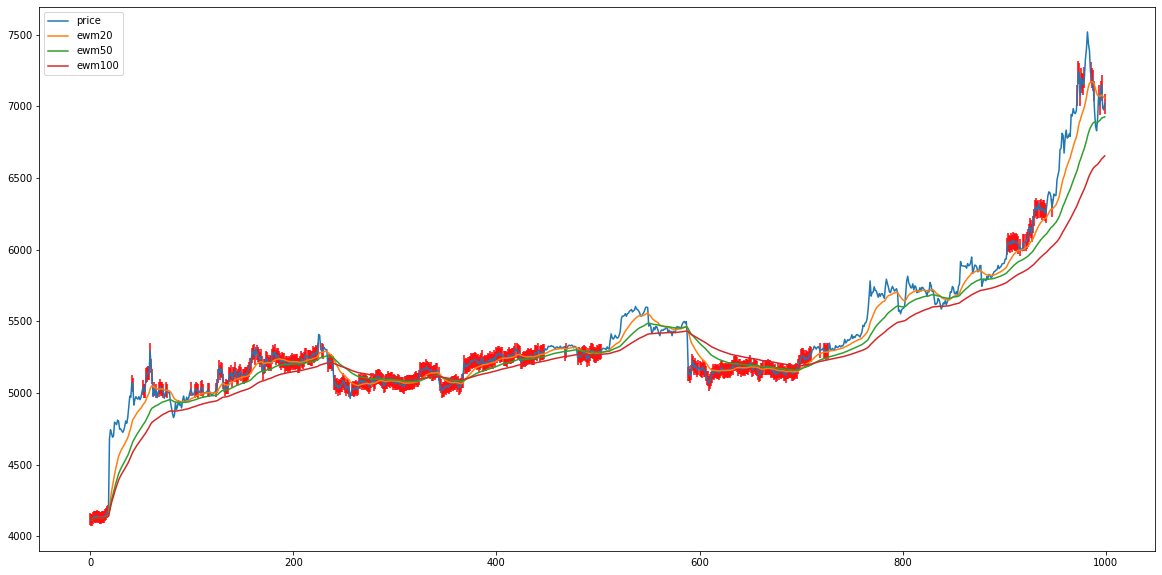

In [8]:
plt.figure(figsize=(20,10))
plt.plot(df.Close)
plt.plot(df.ewm20)
plt.plot(df.ewm50)
plt.plot(df.ewm100)
def buy_check(indicator):
    return (indicator < 0.3) and (indicator > 0.01)
steps2buy = df[df.SR_indicator.apply(buy_check)]
plt.vlines(list(steps2buy.index), steps2buy.Close*0.99, steps2buy.Close*1.01, colors='red')
plt.legend(['price', 'ewm20', 'ewm50', 'ewm100'])

plt.show()

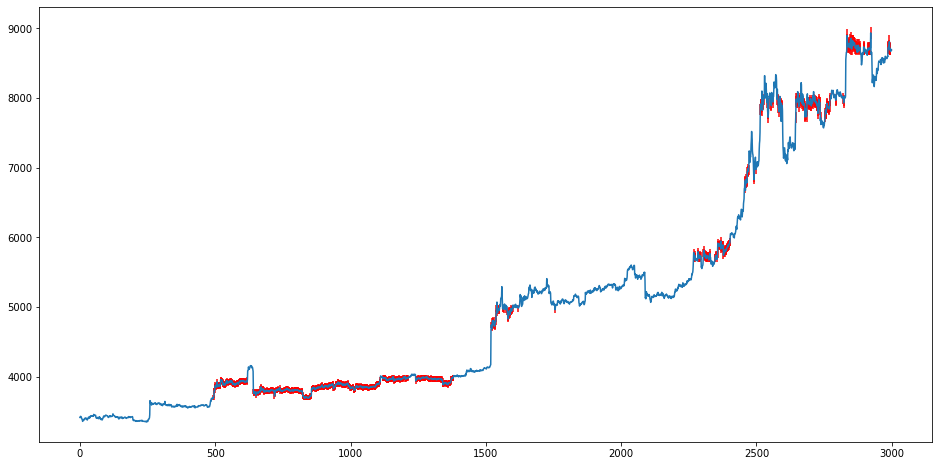

In [119]:
plt.figure(figsize=(16,8))
plt.plot(df.Close)
plt.plot(df.ewm20)
plt.plot(df.ewm50)
plt.plot(df.ewm100)

def sell_check(indicator):
    return (indicator < 0.99) and (indicator > 0.7)

steps2sell = df[df.SR_indicator.apply(sell_check)]
plt.vlines(list(steps2sell.index), steps2sell.Close*0.99, steps2sell.Close*1.01, colors='red')
plt.show()

In [6]:
 fee = 0.0005
 thr_sell = 0.7
 thr_buy = 0.3

In [21]:
dSR_indicator 

0        0.450000
1        0.450000
2        0.449200
3        0.442500
4        0.449900
           ...   
52828    0.941977
52829    0.060917
52830    0.130718
52831    0.153609
52832    0.149812
Name: Close, Length: 52833, dtype: float64

# Tradingview

In [2]:
from tradingview.credentials import get_cred, save_cred
from tvDatafeed import TvDatafeed, Interval

In [3]:
# save_cred()
user, pwd = 'ayd98@mail.ru', 'czh5rqpd'

In [4]:
tv = TvDatafeed(username=user, password=pwd)

In [17]:
btc_data = tv.get_hist('BTC', 'CME', Interval.in_1_hour, n_bars=100_000, fut_contract=1, )
# btc_data = tv.get_hist('BTC', 'BINANCE', Interval.in_30_minute, n_bars=1_000, fut_contract=1)


In [11]:
# btc_data

In [14]:
365*24*8 * 2

140160

<AxesSubplot:xlabel='datetime'>

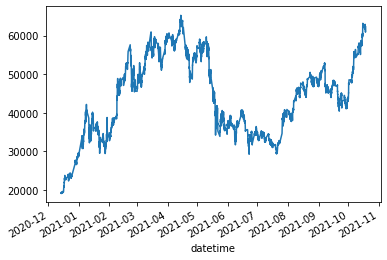

In [18]:
btc_data.close.plot()

In [10]:
class Trader:
    def __init__(self, capital=100):
        self.balance = capital

    def buy(self, value):
        self.balance -= value

    def sell(self, value):
        self.balance += value
        

## yahoo


In [4]:
# import yfinance as yf
# stock = 'BTC'
# data = yf.download(stock, '2018-01-01', '2021-10-10')
# data